<div style="width: 100%; clear: both;">
    <div style="float: left; width: 50%;">
        <img src="../figs/uoc_masterbrand_3linies_positiu.png", align="left">
    </div>
    <div style="float: right; width: 50%;">
        <p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
        <p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
        <p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
    </div>
</div>
<div style="width:100%;">&nbsp;</div>

# Ejemplo de análisis de series temporales (TSA)

En este ejemplo trabajaremos con redes neuronales recurrentes en un problema de regresión con datos generados sintéticamente, a partir de la librería `Keras`.

Al inicio del ejemplo veremos cómo generar datos de forma sintética para una serie temporal. A continuación, trataremos de eliminar tendencias y estacionalidades para preparar los datos y, finalmente, con los datos normalizados, entrenaremos varios modelos que permitirán predecir los valores futuros de la serie.

# 1. Carga de las librerías

El siguiente código carga los paquetes necesarios para este ejemplo.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from stldecompose import decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# 2. Generación de los datos sintéticos

En este ejemplo trabajaremos con una serie temporal generada sintéticamente utilizando `numpy`. 

El siguiente código genera una serie temporal con cierta aleatoriedad, guarda la serie en la variable `serie` y la visualiza en una gráfica.

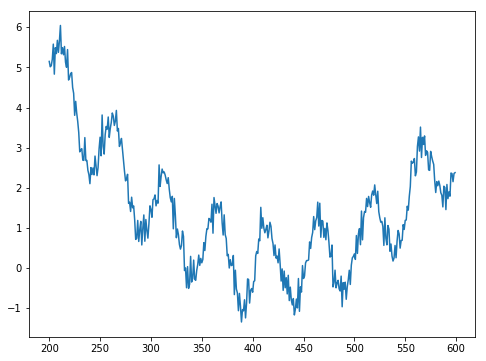

In [2]:
# función para generar los datos de la serie
def f(x):
    return np.square(-x+425)/10000 + np.sin(x/8) + 0.25*np.random.randn()

# datos de la serie
idx = np.arange(200, 600)
serie = [f(x) for x in idx]

# visualización de la serie
plt.rc("figure", figsize=(8,6))
plt.plot(idx, serie)
plt.show()

# 3. Eliminar la tendencia y estacionalidad

Para que la red neuronal pueda extraer patrones de la serie temporal es necesario transformar la serie para que los valores estén siempre en el mismo rango. Para ello, podemos extraer la **tendencia** y la **estacionalidad** de la serie y deshacer el cambio en el momento de obtener predicciones.

En este caso de ejemplo, al haber generado los datos de forma sintética, podemos calcular la periodicidad exacta a través de la fórmula de generación de datos. Dado que el seno es una función periódica de periodo $2*\pi$, el periodo de la serie será aquel valor de $x$ tal que $x$ / 8 = $2*\pi$, que, redondeado a un número entero, es 50.

A continuación, procederemos a extraer la tendencia y la estacionalidad de forma empírica utilizando la función `decompose` del paquete `stldecompose` y dibujarla con el método `plot` de la misma librería.

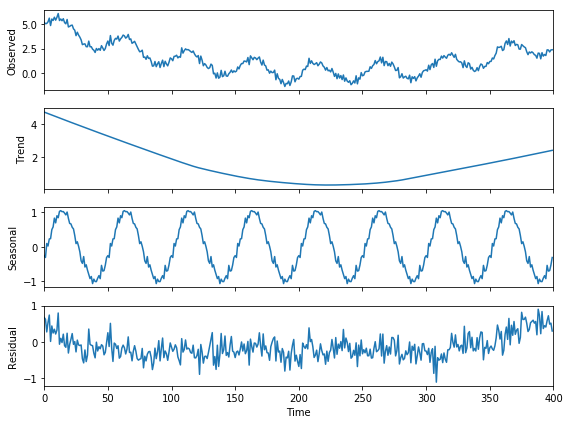

In [3]:
# descomposición de la serie
decomp = decompose(serie, period=50)
decomp.plot()
plt.show()

A continuación, procederemos a repetir la extracción de tendencia y estacionalidad utilizando diferentes valores para el periodo, con el fin de ver la relevancia de determinar el período en la extracción de la tendencia y la estacionalidad. Probaremos con valores múltiplos y divisores del periodo, así como con otros valores al azar.

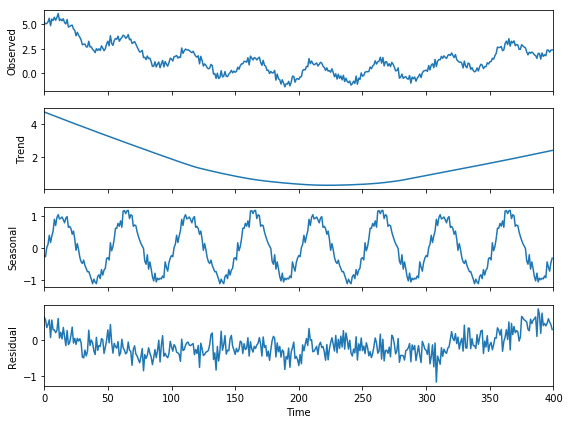

In [4]:
# descomposición de la serie
decomp_100 = decompose(serie, period=100)
decomp_100.plot()
plt.show()

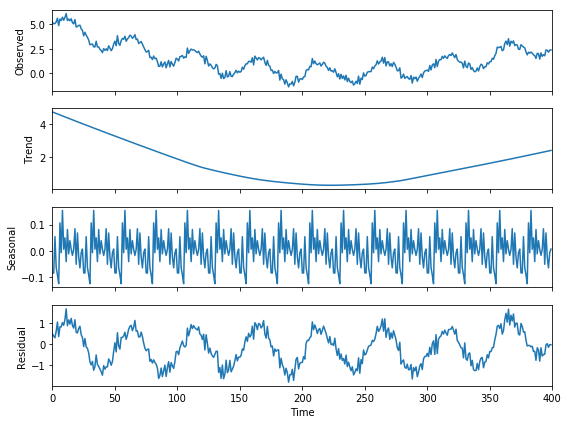

In [5]:
# descomposición de la serie
decomp_25 = decompose(serie, period=25)
decomp_25.plot()
plt.show()

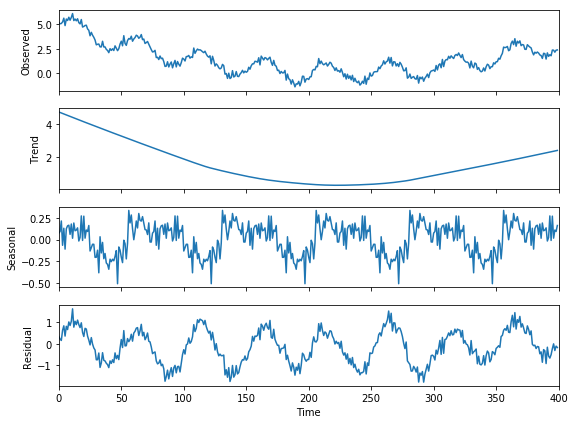

In [6]:
# descomposición de la serie
decomp_75 = decompose(serie, period=75)
decomp_75.plot()
plt.show()

A partir de los ejemplos anteriores y la importancia de calcular correctamente el periodo estacional de una serie temporal, podemos determinar que:

- Si se utiliza un **múltiplo del periodo correcto**, la descomposición se hace bien.
- Si se utilizan **otros valores**, la descomposición pierde completamente el sentido.

Existen muchos otros métodos para eliminar la tendencia y estacionalidad de una serie.

Una posibilidad consiste en transformar la serie haciendo $y[t] = x[t] - x[t-1]$. En este caso, las principales diferencias con el ejemplo visto son:

- Se puede utilizar en cualquier caso y no hace falta averiguar el periodo de estacionalidad.
- Se pierde la "memoria" de la red, ya que el valor $y[t]$ solo depende de los valores de la serie en $t-1$ y $t$.

# 4. Predicción de la tendencia

La tendencia de una serie temporal cambia lentamente con el tiempo. Además, en el momento de realizar predicciones normalmente toma valores fuera del rango que aparece en los datos de entrenamiento. Esto fuerza al modelo a extrapolar, por lo que hay que utilizar modelos muy robustos para predecir la tendencia.

En primer lugar, entrenaremos un modelo polinomial con las variables $x$ y $x^2$ para predecir los valores de la tendencia en el conjunto de entrenamiento, empleando la librería `LinearRegression`.

In [7]:
# Preparación de los datos y entrenamiento del modelo
features = np.hstack([idx.reshape(-1, 1), np.square(idx.reshape(-1, 1))])
reg = LinearRegression().fit(features, decomp.trend)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


En el siguiente fragmento de código crearemos una gráfica con la tendencia original y su predicción.

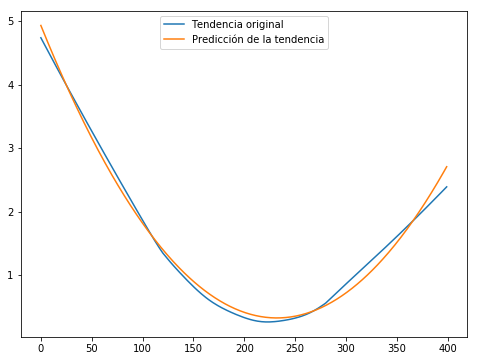

In [8]:
# Visualización de la tendencia original y la predicción
plt.rc("figure", figsize=(8,6))
plt.plot(decomp.trend, label="Tendencia original")
plt.plot(reg.predict(features), label="Predicción de la tendencia")
plt.legend(loc="upper center")
plt.show()